### Link to your presentation video here

# Problem Statement
## FIFA 20
Football is arguably the most popular sport in the world and FIFA is the most popular football (soccer) simulation game by Electronic Arts (EA Sports). 

The game is not to be confused with the official International Federation for Football (FIFA).

You are given the following public dataset, scraped from https://sofifa.com. The data lists soccer players from the 2015-2020 editions of EA Sports FIFA video game. It consists of player positions, player attributes and personal data.


## Problem 
The player club changes can be tracked using the unique Sofifa id across all years. The problem statement is as follows: 

## Part A - Rank the Players      
- Who is the best player in the world according to your analysis?
- Use data from FIFA 19. Predict the Overall (OVR ) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19

- Graphically represent the Overall data for the players in test set (see below)

### Instructions : 
- Sofifa Id, URL, Name, Potential, Real face, URL variables cannot be used during the prediction or learning. 

- In case of a change in playing position, alter FIFA 20 position to match FIFA 19 Position 

- The final score will be assigned using MSE. 

- Test Set: Players from the following Clubs 

  - FC Barcelona

  - FC Bayern München

  - Real Madrid 

  - Paris Saint-Germain

  - Juventus

  - Manchester City

  - Liverpool FC

----------------------------------------------------------------------------------------------------------------

### Importing all the necessary libraries

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#custom function
from preprocess import preprocess
%matplotlib inline

pd.set_option('display.max_columns', 100)

### Load the dataset

In [2]:
fifa_19 = pd.read_csv('data/players_19.csv')

# display first 5 rows
fifa_19.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,player_traits,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,Juventus,94,94,77000000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,127100000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,81.0,89.0,35.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,"Power Free-Kick, Diver, Flair, Long Shot Taker...",84,94,89,81,87,88,...,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,FC Barcelona,94,94,110500000,565000,"CF, RW, ST",Left,5,4,4,Medium/Medium,Messi,Yes,226500000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...",RW,10.0,NaN,2004-07-01,2021.0,CF,10.0,88.0,91.0,88.0,96.0,32.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,"Finesse Shot, Long Shot Taker (CPU AI Only), S...",77,95,70,90,86,97,...,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,90+2,84+2,84+2,84+2,90+2,63+2,61+2,61+2,61+2,63+2,58+2,47+2,47+2,47+2,58+2
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,93,118500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,228100000.0,"#Speedster, #Dribbler, #FK Specialist, #Acroba...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,92.0,84.0,83.0,95.0,32.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,"Diver, Selfish, Flair, Speed Dribbler (CPU AI ...",79,87,62,84,84,96,...,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3
3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,Manchester United,91,93,72000000,260000,GK,Right,4,3,1,Medium/Medium,Lean,Yes,138600000.0,NaN,GK,1.0,NaN,2011-07-01,2019.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,85.0,87.0,94.0,58.0,88.0,"GK Long Throw, Saves with Feet",17,13,21,50,13,18,...,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,Manchester City,91,92,102000000,355000,"CAM, CM",Right,4,5,4,High/High,Normal,Yes,196400000.0,"#Dribbler, #Playmaker , #Engine, #Distance Sh...",RCM,17.0,NaN,2015-08-30,2023.0,RCM,7.0,77.0,86.0,92.0,87.0,60.0,78.0,NaN,N

In [3]:
unique_players = fifa_19.sofifa_id.nunique()
print("Total number of unique players:", unique_players)

Total number of unique players: 17770


# EDA

In [4]:
# calculate correlation of all features with respect to 'Overall'
corr = fifa_19.corr()["overall"].sort_values(ascending=False)

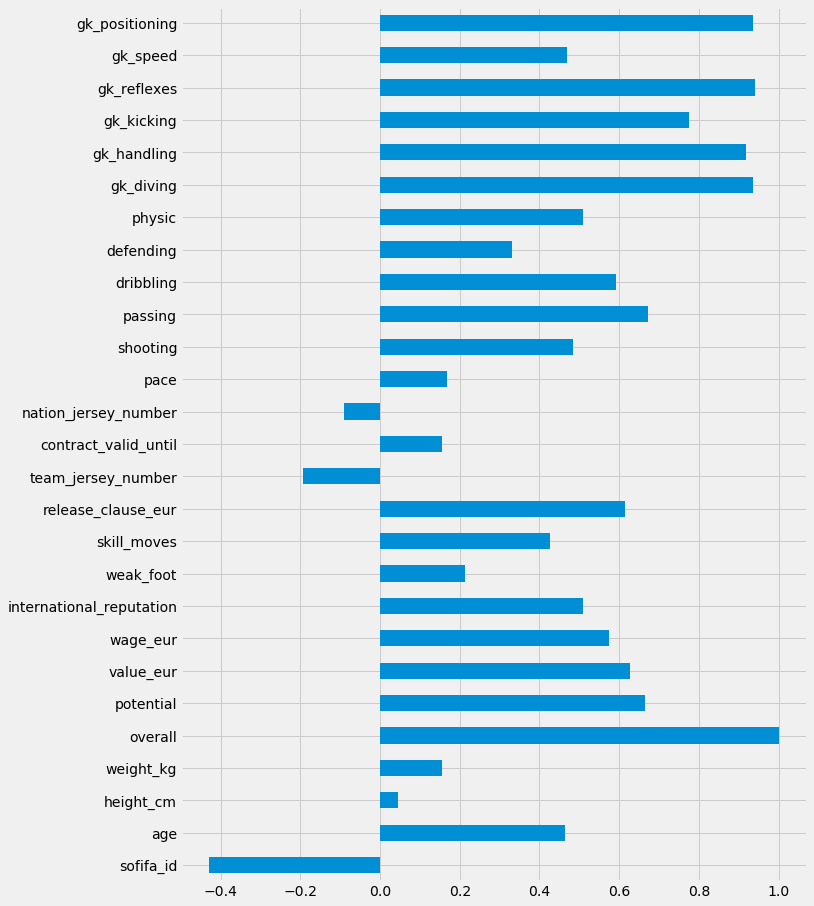

In [5]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 15))
fifa_19.corr()['overall'].plot.barh()
plt.show()

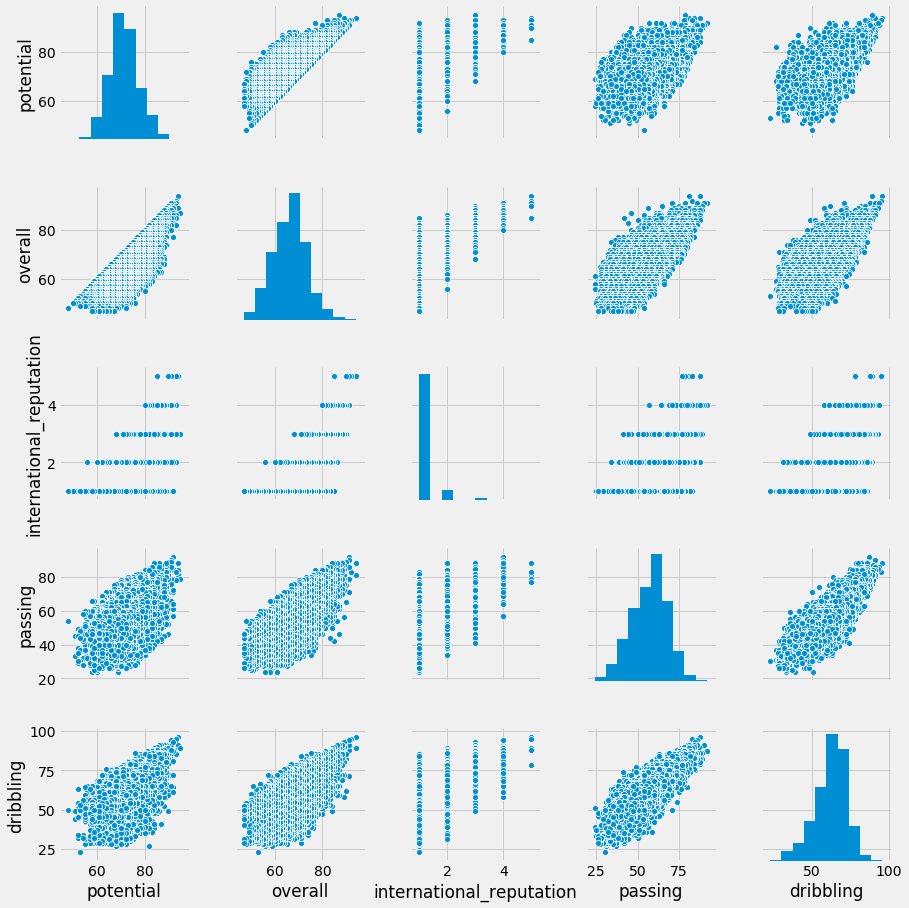

In [6]:
cols = fifa_19[['potential', 'overall', 'international_reputation', 'passing', 'dribbling']]   
sns.pairplot(cols)
plt.show()

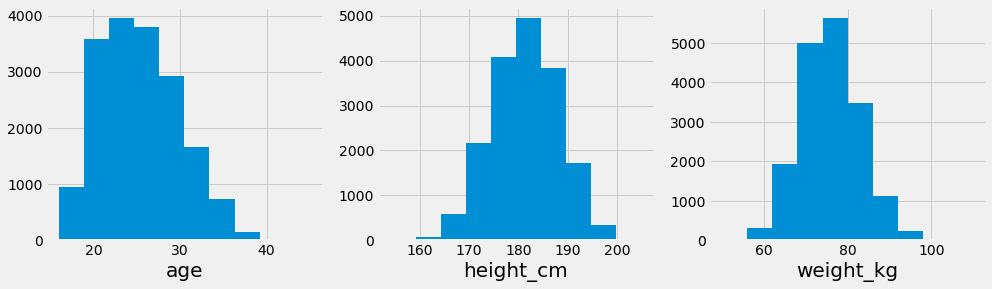

In [7]:
cols = ['age', 'height_cm', 'weight_kg']
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(cols):
    ax[i].hist(fifa_19[col])
    ax[i].set_xlabel(col, fontsize=20)
plt.show()

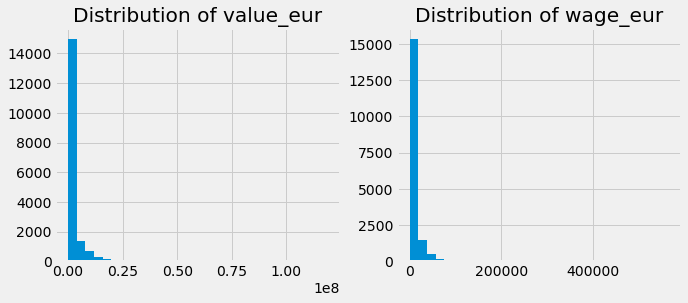

In [8]:
cols = ['value_eur', 'wage_eur']
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, col in enumerate(cols):
    ax[i].hist(fifa_19[col], bins=30)
    ax[i].set_title(f"Distribution of {col}")
plt.show()

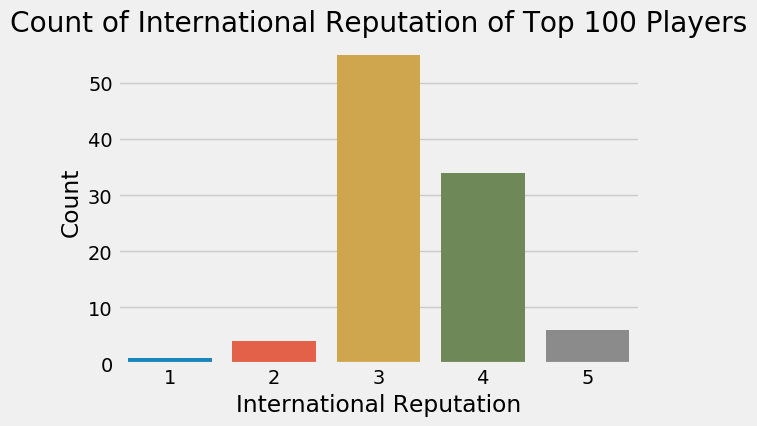

In [9]:
# sns.set_style('white')
plt.figure(dpi=100)
sns.countplot('international_reputation',data=fifa_19.head(100))
plt.xlabel('International Reputation')
plt.ylabel('Count')
plt.title('Count of International Reputation of Top 100 Players')
plt.show()

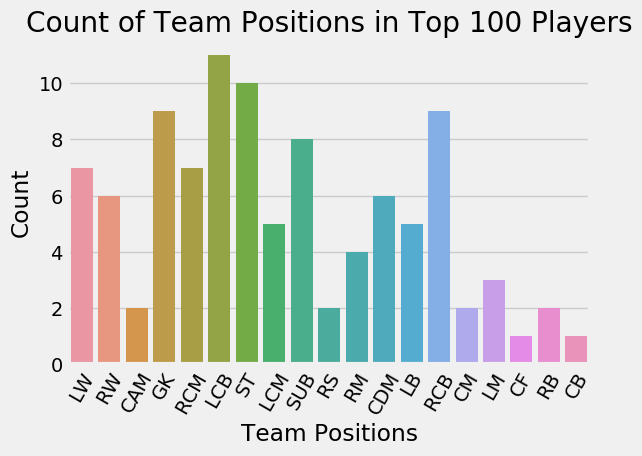

In [10]:
plt.figure(dpi=100)
sns.countplot('team_position',data=fifa_19.head(100))
plt.xlabel('Team Positions')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.title('Count of Team Positions in Top 100 Players')
plt.show()

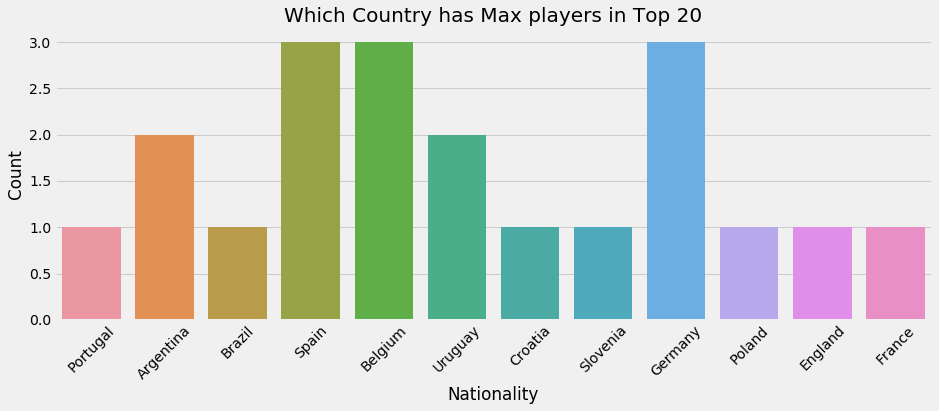

In [11]:
plt.figure(figsize=(14,5))
sns.countplot('nationality',data=fifa_19.head(20))
plt.xlabel('Nationality')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Which Country has Max players in Top 20',fontsize = 20)
plt.show()

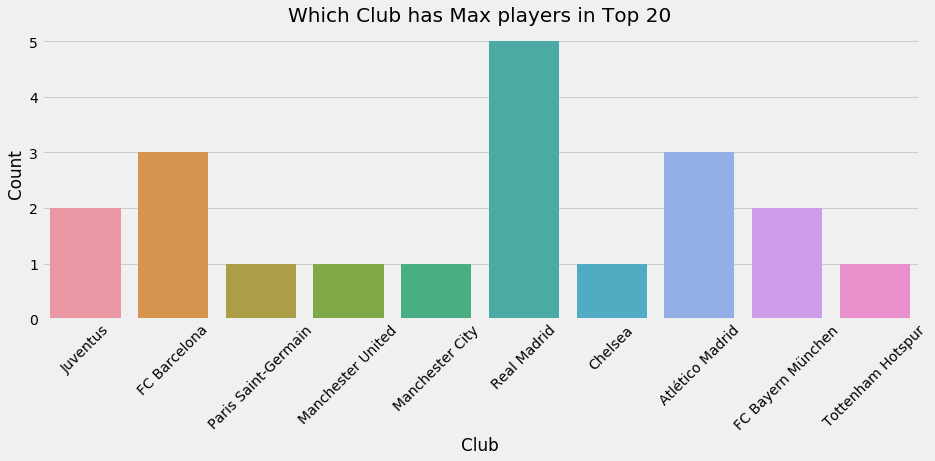

In [12]:
plt.figure(figsize=(14,5))
sns.countplot('club',data=fifa_19.head(20))
plt.xlabel('Club')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Which Club has Max players in Top 20',fontsize = 20)
plt.show()

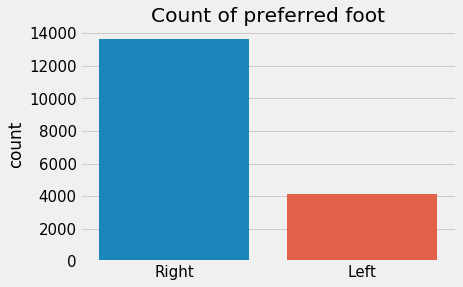

In [13]:
# count number of players by preferred foot
sns.countplot(fifa_19.preferred_foot)
plt.title("Count of preferred foot")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

# Preprocess: Data Cleaning & Handling Missing Values

In [14]:
# preprocess is a custom function that will drop all the unnecessary columns and 
# fills the missing values using appropriate strategy
fifa_19_prerpocessed = preprocess(fifa_19)

In [15]:
fifa_19_prerpocessed.head()

,age,height_cm,weight_kg,overall,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,release_clause_eur,contract_valid_until,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,gk_reflexes,gk_speed,gk_positioning,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,33,187,83,94,77000000,405000,Right,5,4,5,High/Low,127100000.0,2022.0,90.000000,93.000000,81.000000,89.000000,35.000000,79.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,7,11,15,14,11,91,91,91,89,90,90,90,89,88,88,88,88,81,81,81,88,65,61,61,61,65,61,53,53,53,61
1,31,170,72,94,110500000,565000,Left,5,4,4,Medium/Medium,226500000.0,2021.0,88.000000,91.000000,88.000000,96.000000,32.000000,61.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,77,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,6,11,15,14,8,88,88,88,92,93,93,93,92,93,93,93,90,84,84,84,90,63,61,61,61,63,58,47,47,47,58
2,26,175,68,92,118500000,290000,Right,5,5,5,High/Medium,228100000.0,2022.0,92.000000,84.000000,83.000000,95.000000,32.000000,59.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,9,9,15,15,11,84,84,84,89,89,89,89,89,89,89,89,88,81,81,81,88,65,60,60,60,65,60,47,47,47,60
3,27,193,76,91,72000000,260000,Right,4,3,1,Medium/Medium,138600000.0,2019.0,67.815319,52.248733,57.082172,62.267169,51.665484,64.972567,90.000000,85.000000,87.000000,94.000000,58.00000,88.000000,17,13,21,50,13,18,21,19,51,42,57,58,60,90,43,31,67,43,64,12,38,30,12,68,40,68,15,21,13,90,85,87,88,94,60,60,60,63,61,61,61,63,62,62,62,61,60,60,60,61,59,62,62,62,59,61,63,63,63,61
4,27,181,70,91,102000000,355000,Right,4,5,4,High/High,196400000.0,2023.0,77.000000,86.000000,92.000000,87.000000,60.000000,78.000000,65.374622,62.931017,61.511078,66.149043,38.67573,63.088117,93,83,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,60,87,94,79,88,67,58,51,15,13,5,10,13,82,82,82,87,87,87,87,87,88,88,88,88,87,87,87,88,77,77,77,77,77,73,66,66,66,73


In [16]:
# OneHotEncode Categorical Variables
fifa_dummies = pd.get_dummies(fifa_19_prerpocessed, drop_first=True)
# print the shape
fifa_dummies.shape

(17770, 92)

## Split into training and testing data

In [17]:
# copy the onehotencoded dataframe
fifa_final = fifa_dummies.copy()
# separate the predictors and response variables
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14216, 91), (3554, 91), (14216,), (3554,))

# Train different Models

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def display(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std:", scores.std())

In [19]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model_scores = {}
    
    # cross-validation
    scores = cross_val_score(model, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
    scores = -(scores)
    mean_score = scores.mean()
    std = scores.std()
    model_scores["mean"] = f"{mean_score:.2f}"
    model_scores['standard_deviation'] = f"{std:.2f}"
    return model_scores

In [20]:
# creating an object of three different models
lreg = LinearRegression()
knn = KNeighborsRegressor()
rf = RandomForestRegressor(n_estimators=233)

lreg_score = train_and_evaluate(lreg, X_train_sc, y_train, X_test_sc, y_test)
knn_score = train_and_evaluate(knn, X_train_sc, y_train, X_test_sc, y_test)
rf_score = train_and_evaluate(rf, X_train_sc, y_train, X_test_sc, y_test)

scores = [lreg_score, knn_score, rf_score]

In [21]:
scores_df = pd.DataFrame(scores, index =["Linear Regression", "KNeighbors Regressor", "Random Forest Regressor"])
scores_df.columns = ["MSE", "STD"]
scores_df

,MSE,STD
Linear Regression,4.79,0.11
KNeighbors Regressor,2.49,0.07
Random Forest Regressor,0.41,0.05


# Training Random Forest Model On Whole Dataset

In [22]:
fifa_final = fifa_dummies.copy()
X = fifa_final.drop('overall', axis=1)
y = fifa_final.overall

# scale the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=233)
rf.fit(X_scaled, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=233, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [23]:
# saving the trained model
joblib.dump(rf,'best_rf.h5')

['best_rf.h5']

## Predict on 2020 Fifa Dataset

In [24]:
# load fifa 2020 dataset
fifa_2020 = pd.read_csv('data/players_20.csv')

# filter out the clubs which will be used for prediction
clubs = ['FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Manchester City', 'Liverpool']
# preprocess the data
fifa_20_cleaned = preprocess(fifa_2020, True)
# assign categorical columns to be one hot encoded
OneHotCols = ['preferred_foot', 'work_rate']
# OneHotEncode categorical columns
final_dummies = pd.get_dummies(fifa_20_cleaned, columns=OneHotCols, drop_first=True)
# only keep necessary rows
def func(se):
    if se in clubs:
        return True
    return False 

final_dummies['mask'] = final_dummies.club.apply(func)
final_test = final_dummies[final_dummies['mask']]

In [25]:
# separate predictor and response
X_test = final_test.drop(['overall', 'club', 'mask', 'short_name'], axis=1)
y_test = final_test.overall

# scale the X_test
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.metrics import mean_squared_error

# load model
model = joblib.load('best_rf.h5')
# make prediction using the trained model
final_preds = model.predict(X_test_scaled)
# print mean squared error
print("Mean Squared Error: {:.3f}".format(mean_squared_error(y_test, final_preds)))

Mean Squared Error: 0.530


In [27]:
# Create a dataframe using necessary columns that will be used for visualizaiton
df = final_test[['club', 'overall', 'short_name']].copy()
# # add prediction to the dataframe
df['prediction'] = final_preds
# # sort the datafame in descending order by predictions
df_sorted = df.sort_values(by='prediction', ascending=False)
# # print first five rows
df.head()

,club,overall,short_name,prediction
0,FC Barcelona,94,L. Messi,92.811159
1,Juventus,93,Cristiano Ronaldo,91.536481
2,Paris Saint-Germain,92,Neymar Jr,91.373391
4,Real Madrid,91,E. Hazard,91.175966
5,Manchester City,91,K. De Bruyne,90.802575


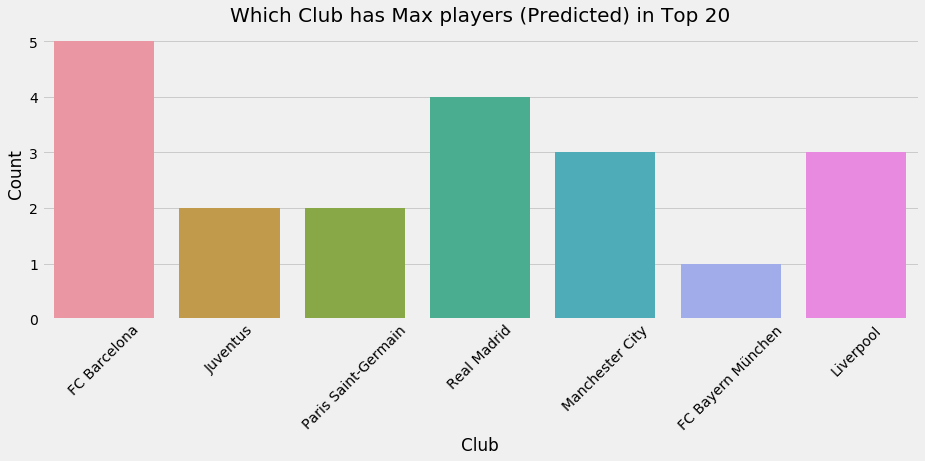

In [28]:
plt.figure(figsize=(14,5))
sns.countplot('club',data=df_sorted.head(20))
plt.xlabel('Club')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Which Club has Max players (Predicted) in Top 20',fontsize = 20)
plt.savefig("club_top_20.pdf", bbox_inches='tight', transparent=True)
plt.show()

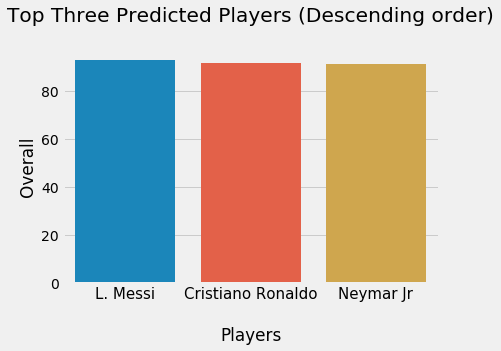

In [29]:
# Top three predict players
plt.style.use('fivethirtyeight')
ax = sns.barplot(df_sorted.head(3)['short_name'], df_sorted.head(3)['prediction'])
ax.set_title("Top Three Predicted Players (Descending order)\n")
ax.set_ylabel("Overall")
ax.set_xlabel("\nPlayers")
plt.xticks(fontsize=15)
plt.savefig('top3.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [30]:
# get top 10 predicted scores
top_10_predictions = df_sorted.iloc[:10, 3].values
# get first 10 actual scores 
actual = df_sorted.iloc[:10, 1].values
# get the names of the first 10 players
top_10_players = df_sorted.iloc[:10, 2].values

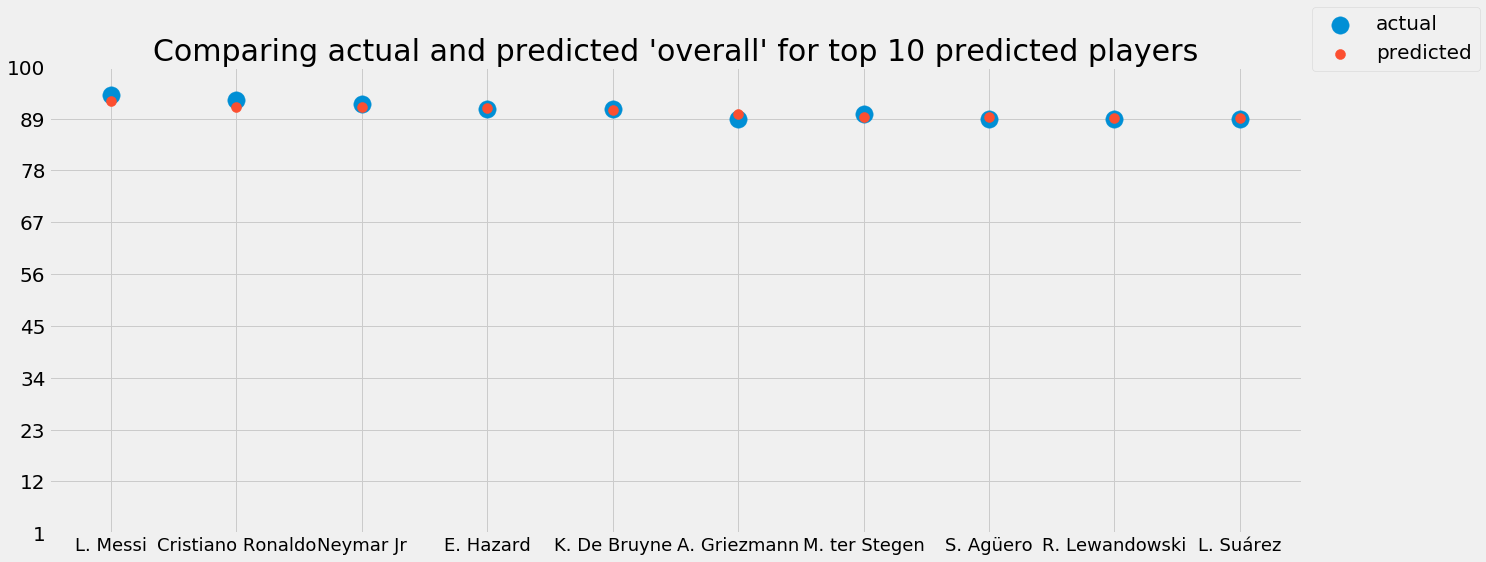

In [31]:
# create xticks for side-by-side bar plot
xticks1 = np.arange(10)
xticks2 = xticks1+0.4

plt.style.use('fivethirtyeight')
# plot
plt.figure(figsize=(20, 8))
plt.scatter(xticks1, actual, label="actual", s=300)
plt.scatter(xticks1, top_10_predictions, label="predicted", s=100)
plt.xticks(xticks1, top_10_players, fontsize=18)
plt.yticks(np.linspace(1, 100, 10), fontsize=20)
plt.title("Comparing actual and predicted 'overall' for top 10 predicted players", fontsize=30)
plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1, 1.15))
plt.show()

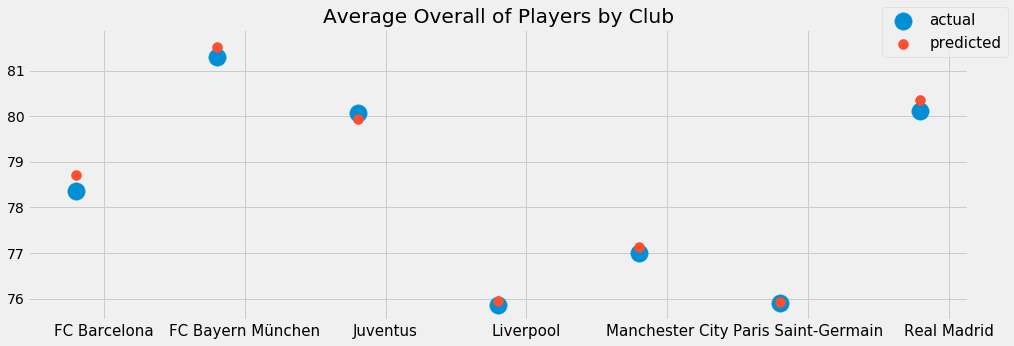

In [32]:
ax = df.groupby('club')['overall'].mean()
ax1 = df.groupby('club')['prediction'].mean()
# plot
plt.figure(figsize=(15, 5))
plt.scatter([1, 1.5, 2, 2.5, 3, 3.5, 4], ax.values, label="actual", s=300)
plt.scatter([1, 1.5, 2, 2.5, 3, 3.5, 4], ax1.values, label="predicted", s=100)
plt.xticks([1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1], labels=list(ax.index), fontsize=15)
plt.title("Average Overall of Players by Club")
plt.legend(bbox_to_anchor=(0.9, 1.1), loc='upper left', fontsize=15)
plt.savefig("club.pdf", bbox_inches='tight', transparent=True)
plt.show()

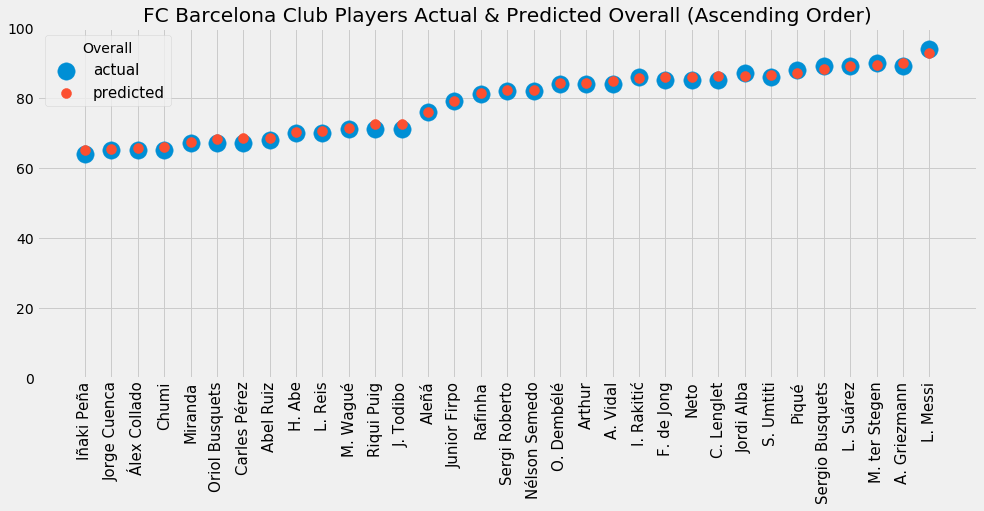

In [33]:
# plot barcelona's players overall
barca = df[df['club'] == 'FC Barcelona']
barca = barca.sort_values(by='prediction')
# plot
xticks = np.arange(len(barca))
plt.figure(figsize=(15, 6))
plt.scatter(xticks, barca.overall, label='actual', s=300)
plt.scatter(xticks, barca.prediction, label='predicted', s=100)
plt.ylim(0, 100)
plt.xticks(ticks=xticks, fontsize=15, rotation=90, labels=barca.short_name)
plt.legend(title='Overall', loc='upper left', fontsize=15)
plt.title("FC Barcelona Club Players Actual & Predicted Overall (Ascending Order)")
plt.show()

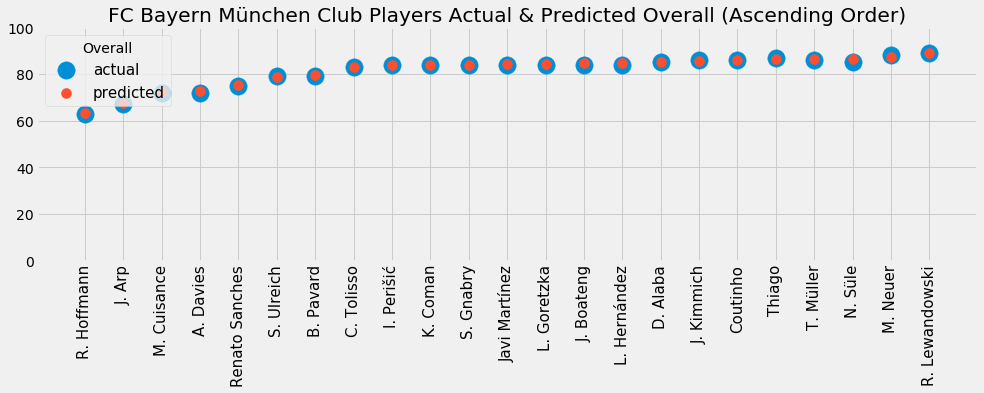

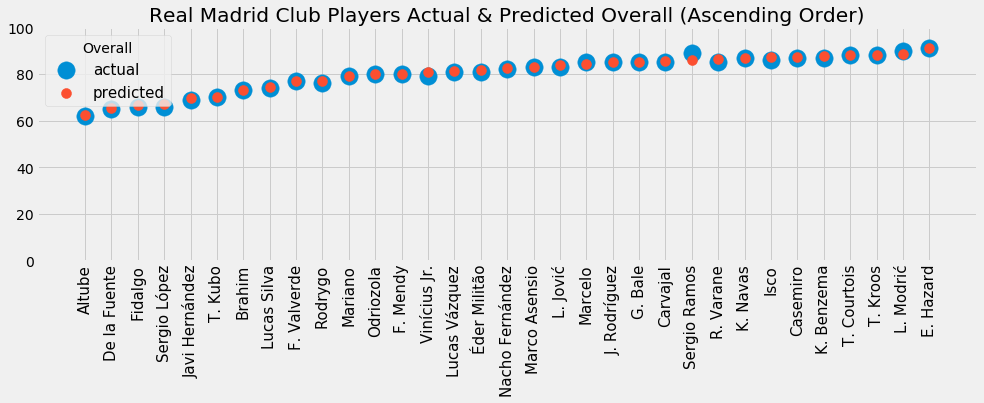

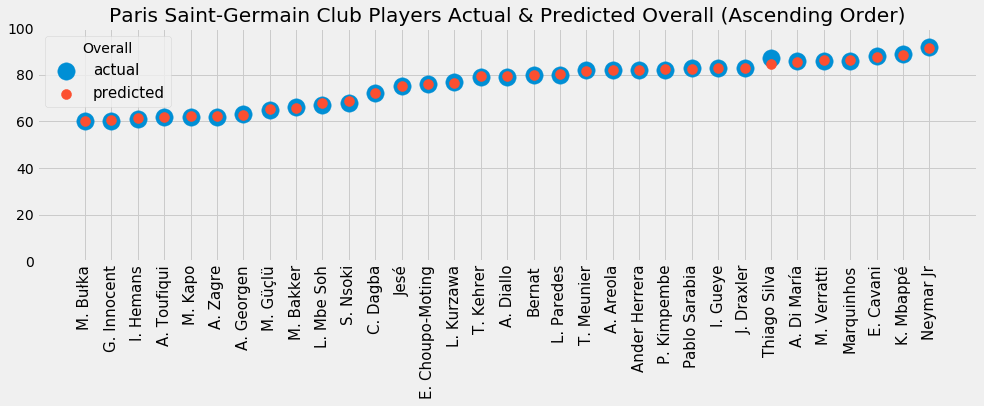

In [34]:
for c in clubs[1:4]:
    new_df = df[df['club'] == c]
    new_df = new_df.sort_values(by='prediction')
    # plot
    xticks = np.arange(len(new_df))
    plt.figure(figsize=(15, 4))
    plt.scatter(xticks, new_df.overall, label='actual', s=300)
    plt.scatter(xticks, new_df.prediction, label='predicted', s=100)
    plt.ylim(0, 100)
    plt.xticks(ticks=xticks, fontsize=15, rotation=90, labels=new_df.short_name)
    plt.legend(title='Overall', loc='upper left', fontsize=15)
    plt.title(f"{c} Club Players Actual & Predicted Overall (Ascending Order)")
    plt.show()

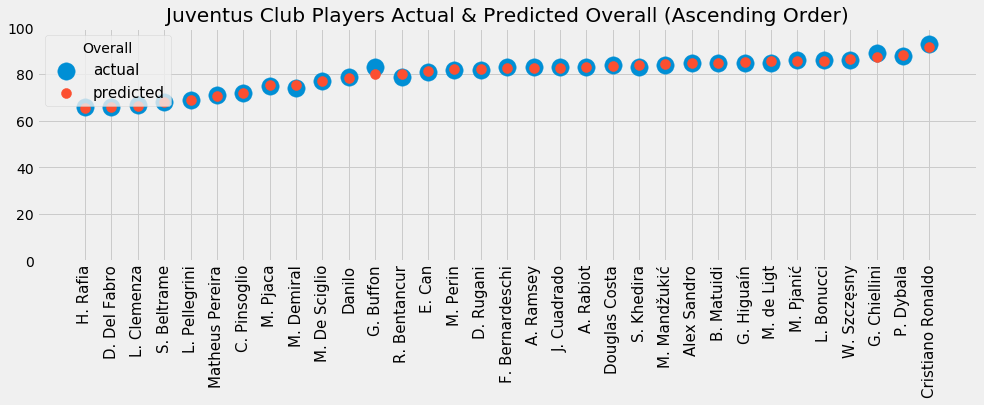

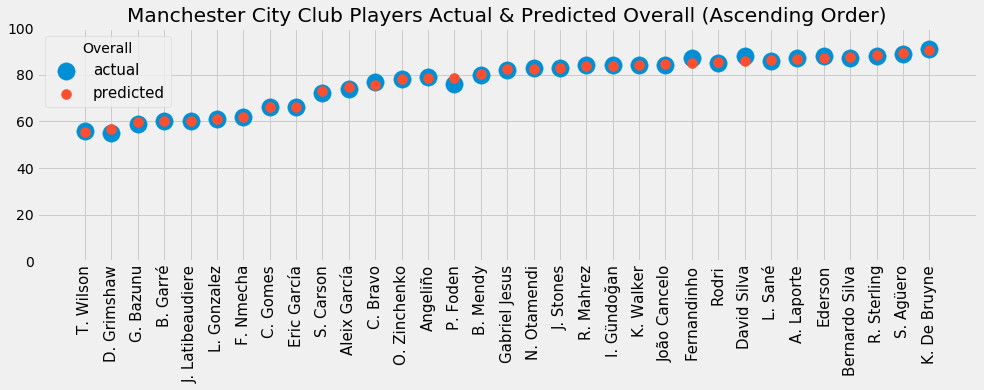

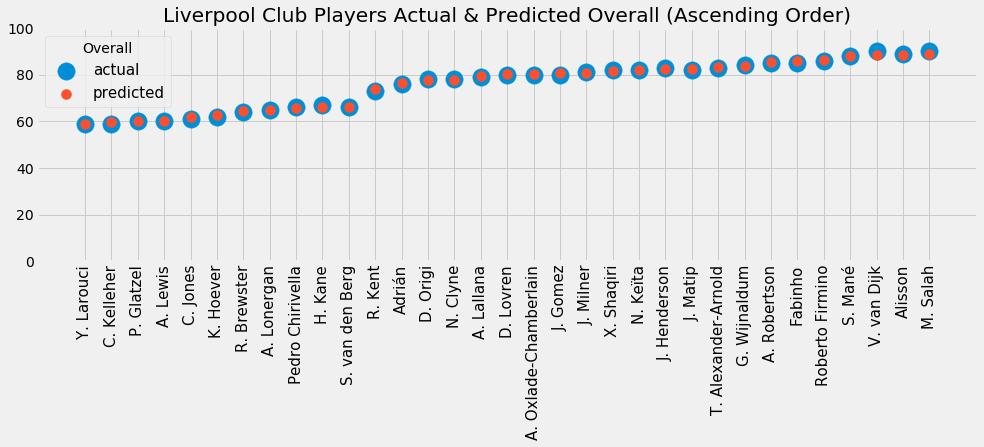

In [35]:
for c in clubs[4:]:
    new_df = df[df['club'] == c]
    new_df = new_df.sort_values(by='prediction')
    # plot
    xticks = np.arange(len(new_df))
    plt.figure(figsize=(15, 4))
    plt.scatter(xticks, new_df.overall, label='actual', s=300)
    plt.scatter(xticks, new_df.prediction, label='predicted', s=100)
    plt.ylim(0, 100)
    plt.xticks(ticks=xticks, fontsize=15, rotation=90, labels=new_df.short_name)
    plt.legend(title='Overall', loc='upper left', fontsize=15)
    plt.title(f"{c} Club Players Actual & Predicted Overall (Ascending Order)")
    plt.show()

# ==============================================================

# Hyper-parameter Tuning (Random Forest)
## We can see that the Ranfom Forest performed way better than the other two, we can tune Random Forest for more better results

**Note:** This code can take more than 30 mins to execute

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 7, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 3, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train_sc, y_train)

In [ ]:
# best_rf = rf_random.best_estimator_
# # RandomForerstRegressor
# # rf = RandomForestRegressor(n_estimators=30)
# rf_scores = cross_val_score(best_rf, X_train_sc, y_train, cv=10, scoring='neg_mean_squared_error')
# display(-rf_scores)